# Plot benchmark success rates

This shows how to plot design benchmark results, in particular how to extract the diversity-adjusted success rate. See README.md for instructions on calculating the benchmark metrics.

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# optional: import sys
sys.path.append("/home/jue/git/formolase/")
from formolase.plotting import set_jue_plotting_defaults, outside_legend
from formolase.functions import *
set_jue_plotting_defaults()

In [5]:
sys.path.append("/home/jue/git/bff-benchmark/rf_diffusion/benchmark/util/")
import analysis_util

## Plot

Load the compiled metrics from 3 different benchmarking runs.

In [149]:
df_s = []

In [150]:
tmp = pd.read_csv('/projects/ml/diffusion_benchmark/20220816_length_test_bugfix/compiled_metrics.csv', index_col=0)
tmp['method'] = 'BFF_wcomplexes_3epochs_072522'
tmp['task'] = tmp['name'].apply(lambda x: x.split('_')[0])
df_s.append(tmp)

In [151]:
tmp.shape

(1564, 82)

In [152]:
tmp = pd.read_csv('/projects/ml/diffusion_benchmark/20220816_length_test_newckpt/compiled_metrics.csv', index_col=0)
tmp['method'] = 'Diff_ss_blockadj_14epochs_originfix_081522'
tmp['task'] = tmp['name'].apply(lambda x: x.split('_')[0])
df_s.append(tmp)

In [153]:
tmp.shape

(400, 82)

In [154]:
tmp = pd.read_csv('/projects/ml/diffusion_benchmark/20220815_inp_length_test/compiled_metrics.csv', index_col=0)
tmp['method'] = 'autofold3'
tmp['task'] = tmp['name'].apply(lambda x: x.split('_')[1])
df_s.append(tmp)

In [155]:
tmp.shape

(1600, 25)

In [156]:
df = pd.concat(df_s)

In [157]:
df.shape

(3564, 84)

In [158]:
df = analysis_util.remove_constant_columns(df)

In [159]:
df.shape

(3564, 72)

In [160]:
df.columns

Index(['name', 'plddt_start', 'plddt_mid', 'plddt_end', 'plddt_mean',
       'sampled_mask', 'inference.input_pdb', 'inference.num_designs',
       'inference.design_startnum', 'inference.ckpt_path',
       'inference.ppi_design', 'inference.autogenerate_contigs',
       'inference.model_only_neighbors', 'inference.num_recycles',
       'inference.softmax_T', 'inference.output_prefix',
       'inference.scaffold_guided', 'inference.model_runner',
       'inference.cautious', 'contigmap.contigs', 'contigmap.length',
       'model.n_extra_block', 'model.n_main_block', 'model.n_ref_block',
       'model.d_msa', 'model.d_msa_full', 'model.d_pair', 'model.d_templ',
       'model.n_head_msa', 'model.n_head_pair', 'model.n_head_templ',
       'model.d_hidden', 'model.d_hidden_templ', 'model.p_drop',
       'model.SE3_param_full', 'model.SE3_param_topk', 'diffuser.T',
       'diffuser.b_0', 'diffuser.b_T', 'diffuser.schedule_type',
       'diffuser.so3_type', 'diffuser.aa_decode_steps', 'diffu

By default the compiled_metrics.csv dataframe is in "tall-form", meaning that MPNN designs are separate from non-MPNN designs. However, they share metadata and are assumed to have the same TM clusters (calculated from non-MPNN designs).

In [161]:
df[df['name']=='rsv5-2_cond0_188']

,name,plddt_start,plddt_mid,plddt_end,plddt_mean,sampled_mask,inference.input_pdb,inference.num_designs,inference.design_startnum,inference.ckpt_path,...,ss_helix_frac,ss_loop_frac,mpnn,tm_cluster_0.40,tm_cluster_0.60,tm_cluster_0.80,method,task,lddt,inpaint_lddt
0,rsv5-2_cond0_188,0.41628,0.615055,0.970083,0.660491,"['13-13,A163-181,42-42']",/home/jue/git/bff/rf_diffusion/benchmark/input...,1.0,188.0,/mnt/home/jwatson3/for/nate/diffusion_models/B...,...,0.351351,0.472973,False,rsv5-2_cond0_clus0,rsv5-2_cond0_clus5,rsv5-2_cond0_clus95,BFF_wcomplexes_3epochs_072522,rsv5-2,NaN,NaN
1,rsv5-2_cond0_188,0.41628,0.615055,0.970083,0.660491,"['13-13,A163-181,42-42']",/home/jue/git/bff/rf_diffusion/benchmark/input...,1.0,188.0,/mnt/home/jwatson3/for/nate/diffusion_models/B...,...,0.351351,0.472973,True,rsv5-2_cond0_clus0,rsv5-2_cond0_clus5,rsv5-2_cond0_clus95,BFF_wcomplexes_3epochs_072522,rsv5-2,NaN,NaN


### Success rate
This is the "final" benchmarking metric, which represents the success rate at various degrees of structural diversity.

In [166]:
# this outputs success rates for each condition in a "tall"-form dataframe, suited to seaborn plotting
success = analysis_util.calc_success_rate(df[df['mpnn']], ['task','method']) # only look at mpnn designs

# you can also request a "wide"-form dataframe instead, but it's more work to plot
# success = analysis_util.calc_success_rate(df, ['task','method'], wide=True)

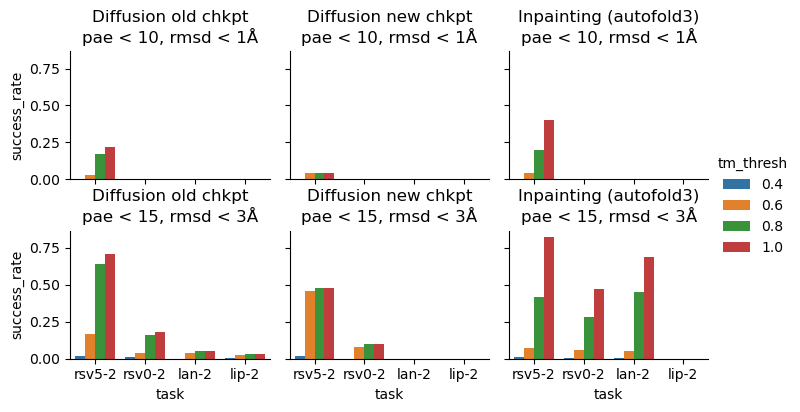

In [167]:
g = sns.catplot(data=success, y='success_rate', x='task', hue='tm_thresh', col='method', row='pae_thresh',
                kind='bar',order=['rsv5-2','rsv0-2','lan-2','lip-2'],
                height=2,aspect=1.2)

# the default display is a bit messy, so override it with easier-to-see titles
for irow,thresh in enumerate(['pae < 10, rmsd < 1Å', 'pae < 15, rmsd < 3Å']):
    for icol,method in enumerate(['Diffusion old chkpt','Diffusion new chkpt','Inpainting (autofold3)']):
        g.axes[irow,icol].set_title(f'{method}\n{thresh}')
        
plt.subplots_adjust(hspace=0.4)

### Various quality metrics
If you want to look at the full distribution across various quality metrics, you could do e.g. the following.

We'd like to view both the design method and MPNN status in the hue variable, so combine these into a single metadata column.

In [172]:
import itertools

In [171]:
df['method / mpnn'] = df.apply(lambda row: row['method']+' / '+str(row['mpnn']),axis=1)

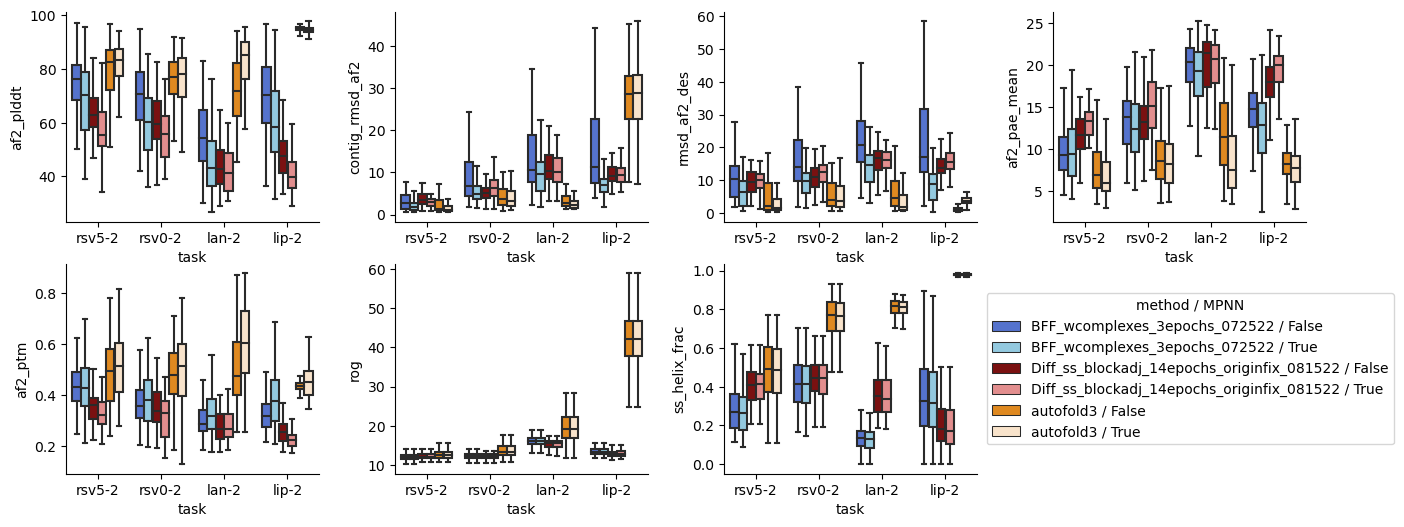

In [175]:
fig, axes = plt.subplots(2,4,figsize=(16,6))
plt.subplots_adjust(wspace=0.3)
for ax,metric in zip(axes.flat, ['af2_plddt','contig_rmsd_af2','rmsd_af2_des','af2_pae_mean',
                                 'af2_ptm','rog','ss_helix_frac']):
    sns.boxplot(ax=ax, data=df, y=metric, x='task', hue='method / mpnn',
                order = ['rsv5-2','rsv0-2','lan-2','lip-2'],
                hue_order=[f'{x} / {y}' for x,y in itertools.product(df['method'].drop_duplicates(), 
                                                                     df['mpnn'].drop_duplicates().astype(str))],
                palette=['royalblue','skyblue','darkred','lightcoral','darkorange','bisque'],
                showfliers=False)
    ax.legend().set_visible(False)
sns.despine()
outside_legend(ax,title='method / MPNN')
axes.flat[-1].set_visible(False)